# Introduction to Quantum Compilation with TKET

In recent years the field of quantum computing has grown from being an obscure and academic pursuit at the intersection of physics and computer science to one of the most rapidly evolving fields in modern science. Developing quantum hardware and algorithms is now a major technological goal for governments and private companies worldwide with numerous applications promised in Chemistry, optimisation, cybersecurity, machine learning and more. 

Present day quantum computers however suffer from prohibitive noise in additon to having complex constraints on permitted operrations and device connectivity that must be solved for before a quantum algorithm can be implemented. 

TKET is a quantum software toolkit and compiler designed to simplify quantum experiments. A traditional compiler can translate a human readble program to a form that can be executed as low level machine code. Analogusly TKET can compile a high level description of a quantum algorithm to a form that can be implemented on a real quantum computer. (compiler diagram here)

Importantly TKET has numerous optimisation tools to reduce the resources needed for near term quantum experiments. Such circuit optimisations can significantly improve the performance of algorithms by effectively mitigating against noise.

## Defining circuits in pytket

Circuits can be defined and visualised easily using the pytket python interface. Lets define an elementary circuit that prepares and measures the familar Bell state.

$$ \left| \psi \right\rangle = \frac{1}{\sqrt{2}} \big( \left| 00 \right\rangle + \left| 11 \right\rangle\big) $$

In [1]:
from pytket import Circuit # import Circuit class
from pytket.circuit.display import render_circuit_jupyter # import circuit renderer

bell_circ = Circuit(2)
bell_circ.H(0)
bell_circ.CX(0,1) 
bell_circ.measure_all()

render_circuit_jupyter(bell_circ)

 User interface icons are available to toggle between the gate based and ZX calculus representations of our Bell circuit [ref].

TKET has many extension modules for interfacing with different types of quantum hardware and classical simulators. Lets simulate our Bell circuit using the idealised ``AerBackend`` Simulator from the pytket-qiskit extension.

In [2]:
from pytket.extensions.qiskit import AerBackend

noiseless_backend = AerBackend()
handle = noiseless_backend.process_circuit(bell_circ , n_shots = 1000) # process our circuit (1000 shots)
result = noiseless_backend.get_result(handle) # retrieve our result using the handle

result_counts = result.get_counts() # use get_counts() method to retrieve {shots:counts} dictionary
print(result_counts)

Counter({(1, 1): 504, (0, 0): 496})


As you can see we obtain approximately equal number of counts in the (0,0) and (1,1) basis states. This is what one would expect from meauring the Bell state. Even although the simulator is noiseless we would not expect an exact 50:50 distribution as there as we are still randomly sampling. If you flip a fair coin 1000 times its unlikely to give heads and tails 500 times each!

So far so good. However the experiment we have just performed is simplitic in many ways. Not only have we simulated a trivial circuit but the ``AerBackend`` has no hardware noise and a diverse set of quantum gates available. Furthermore there are no complications introduced by the qubit layout as the ``AerBackend`` has "all-to-all" connectivity. In a more realistic quantum experiment all of these considerations will need to be taken into account.

Lets consider a slightly more complex example using a phase estimation circuit. Quantum phase estimation (QPE) is an important subrotuine that occurs in many quantum algotihms including Shor's algorithm and Hamiltonian simulation. We could define this cirucit by sequentially adding gates but lets define our circuit from a qasm file. For ease of visualisation we will start with a three qubit circuit.

**EXERCISE:** We have defined this circuit using a QASM file. Can you construct the circuit using pytket? Read more about the structure of phase estimation circuits and see if you can define a function ``build_qpe_circ(n)`` that returns a quantum phase estimation circuit with $n$ measurement qubits.

In [3]:
from pytket.qasm import circuit_from_qasm

qpe2_circ = circuit_from_qasm('qpe2.qasm') # qpe circuit with two measurement qubits and one phase qubit.
render_circuit_jupyter(qpe2_circ)

Our circuit contains single qubit gates (Hadamard and X gates) as well as multi-qubit SWAP and CU1 gates. To read more about how these gates are defined click `here`. We can also count the number of gates in our circuit as follows using the OpType enum.

In [4]:
from pytket import OpType

print('Gate count = ' , qpe2_circ.n_gates)
print('Two qubit gate count = ' ,qpe2_circ.n_gates_of_type(OpType.CU1) + qpe2_circ.n_gates_of_type(OpType.SWAP))

Gate count =  12
Two qubit gate count =  5


Gate count is a natural metric to keep track of when compiling quantum cirucits. The two qubit gate count is particularlly important to bear in mind as these gates can be roughly an order of magnitude noiser and slower to implement on hardware than single qubit gates. In fact much of circuit optimisation focuses on reducing the two qubit gate count as we shall see shortly.

## Understanding Device constraints

From now on we will consider a phase estimation circuit with an extra qubit (and lots of extra gates!). This will hopefully make certain points around circuit compilation clearer.

In [5]:
qpe3_circ = circuit_from_qasm('qpe3.qasm') # qpe circuit with THREE measurement qubits and one phase qubit.
render_circuit_jupyter(qpe3_circ)

print('Gate count = ' , qpe3_circ.n_gates)
print('Two qubit gate count = ' ,qpe3_circ.n_gates_of_type(OpType.CU1) + qpe3_circ.n_gates_of_type(OpType.SWAP))

Gate count =  21
Two qubit gate count =  11


Lets now think about how to run our phase estimation circuit on an actual quantum computer (or at the very least a more realistic simulator! ) Lets use the ``IBMQEmulatorBackend`` from the ``pytket-qiskit`` extension. This is a simulator that attempts to capture the noise of real IBM superconducting device (The IBMQ Belem device is used here) using some noise model. To make our experiment more realitic our circuit must satisfy all the constraints of the real device in order to run on the simulator.

In [6]:
from pytket.extensions.qiskit import IBMQEmulatorBackend

IBMQ_belem_backend = IBMQEmulatorBackend('ibmq_belem', hub='partner-cqc', group='internal', project='default')

Before we can run a circuit on this emulator our circuit must be in the correct gateset. To see which gates are supported we can use the ``backend_info.gate_set`` attribute of our backend.

In [7]:
IBM_gateset = IBMQ_belem_backend.backend_info.gate_set
print(IBM_gateset)

{<OpType.Rz: 33>, <OpType.U3: 34>, <OpType.U2: 35>, <OpType.U1: 36>, <OpType.CX: 39>, <OpType.SX: 28>, <OpType.X: 20>, <OpType.noop: 57>, <OpType.Measure: 58>, <OpType.Reset: 60>}


Notice how the CU1, H and SWAP operations are not in our ``IBM_gateset`` (the X gate is). This means we will have to find some way to translate our circuit to the gates that are supported by our backend.

An addtional constriant that is sometimes forgottten is the circuit connectitity. Textbook presentations of quantum algorithms often assume that all of the qubits a circuit can interact wih one another freely. However when it comes to real quantum devices this may not be the case. For instance the IBM Belem device only allows interaction between qubits which are next to each other. This means that additonal gates must be inserted into our circuit in order to realise all of the interactions in our phase estimation circuit.

We can visualise the connectivity of our phase estimation circuit by looking at the interaction graph.

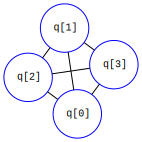

In [8]:
from pytket.utils import Graph

Graph(qpe3_circ).get_qubit_graph()

Notice how we have all possible interactions between our qubits. Put differently, our interaction graph is 
the complete graph $K_4$. Lets now take a look at how our qubits are laid out on the device itself. Bear in mind that only nearest-neighbour interaction is permitted between the qubits.

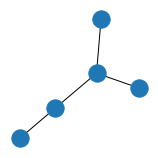

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph(IBMQ_belem_backend.backend_info.architecture.coupling) # interaction graph as a networkx graph
plt.figure(figsize=(2,2))
nx.draw(G)
plt.show() # This is how the qubits are laid out on the device

Notice how the connectivity of the device is places restrictions on the gates that can be performed. We will need to add additional SWAP gates to our cirucits to realise the interactions in our phase estimation cirucit. The problem of satisfying circuit connectivity without adding too many extra gates is called the **qubit routing problem** [ref]. We will not consider routing in detail in what follows (Perhaps in a forthcoming blog post!).

## Circuit Compilation with the Quantinuum Backend.

Now that we understand more about the restrictions imposed by quantum hardware lets find out how TKET can solve for our device constraints and even optimise our circuit for better performance!

TKET is designed to make working with different hardware platforms as seemless as possible. In fact there are numerous extension modules that allow the user to interface with a range of quantum hardware. This enables the user to try out the pros and cons of different hardware platforms without having to rewrite their code.

To demonstrate this lets compile our phase estimtion circuit for a Quantinuum ion trap device. Lets initialse our new backend and see which gates it supports.

In [10]:
from pytket.extensions.quantinuum import QuantinuumBackend

H1E_backend = QuantinuumBackend('H1-1E') # emulator for the H1 ion trap device
gate_set = H1E_backend.backend_info.gate_set
print(gate_set)

Enter your Quantinuum email: callum.macpherson@cambridgequantum.com
Enter your Quantinuum password: ········
{<OpType.ZZMax: 65>, <OpType.Rz: 33>, <OpType.ZZPhase: 68>, <OpType.Barrier: 6>, <OpType.WASM: 12>, <OpType.SetBits: 13>, <OpType.CopyBits: 14>, <OpType.RangePredicate: 15>, <OpType.ExplicitPredicate: 16>, <OpType.ExplicitModifier: 17>, <OpType.MultiBit: 18>, <OpType.ClassicalExpBox: 87>, <OpType.Measure: 58>, <OpType.Reset: 60>, <OpType.PhasedX: 63>}


As mentioned above we need to translate our circuit to the supported gate set. TKET can translate automatically to the target gate set by using the ``get_complied_circuit`` method for our ``QuantinuumBackend``. Lets do this translation and see how it effects the number of gates in our circuit.

In [11]:
compiled_circuit = H1E_backend.get_compiled_circuit(qpe3_circ)
render_circuit_jupyter(compiled_circuit)

print('Gate count = ' , compiled_circuit.n_gates)
print('Two qubit gate count = ' ,compiled_circuit.n_gates_of_type(OpType.ZZMax))

Gate count =  96
Two qubit gate count =  23


Notice how the circuit has now been transformed to the Quantinuum native gateset namely {PhasedX, ZZMax, Rz}. This compilation has also massively increased our gatecount. Compare with our original QPE cirucit with 21 gates and 11 two qubit gates! 

On noisy hardware more gates means errors will accumalte over the course of our computation introduce additional noise in our results. This example serves to motivate cirucit optimisation. The question aries - how can we compile our circuit to our target device without adding to many extra noisy gates?

Pytket can optimise circuits in numerous ways. Each pytket ``Backend`` object has a method called ``default_compilation_pass``.This method applies a predefined sequence of optimistaions to our cirucit that is tailor made for each device. 

This method also takes an ``optimistaion_level`` parameter. Setting ``opimisation_level=1`` will solve for the device constraints and apply some light optimsisation. The highest level of optimisation (``optimisation_level=2``) applys intensive optimisations but may take longer to run for large circuits. 

Lets now apply this default compilation pass to our circuit with the highest level of optimisation available and see how this effects our gate count.

In [13]:
qpe3_circ = circuit_from_qasm('qpe3.qasm')

H1E_backend.default_compilation_pass(optimisation_level=2).apply(qpe3_circ)

render_circuit_jupyter(qpe3_circ)

print('Gate count = ' , qpe3_circ.n_gates)
print('Two qubit gate count = ' ,qpe3_circ.n_gates_of_type(OpType.ZZMax))

Gate count =  48
Two qubit gate count =  11


We now see a huge difference in the gate count compared with the naively compiled circuit. The two qubit gate count is more than halved which will reduce the noise that accumaltes over the course of the computation.

We have managed to find an implementation of our phase estimation circuit that meets our hardware constraints and does not have any additional two qubit gates introduced in the commpilation process.

In this tutorial we have made use of the predefined circuit tranformations applied by the ``get_compiled_circuit`` and ``default_compilation_pass`` methods. TKET also supports user defined sequences of optimisations which will be covered in another tutorial.